In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

In [ ]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(90, 120))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [ ]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
print(x_train.shape[1])

90


RESTNET

In [ ]:
start_time = time.time()


In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
x_train = np.array([np.repeat(img, 3, axis=-1) for img in x_train])
x_test = np.array([np.repeat(img, 3, axis=-1) for img in x_test])

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
resnet_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])


In [ ]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_resnet = resnet_model.fit(x_train, train_labels, epochs=200, validation_data=(x_test, test_labels))


Epoch 1/200
24/24 [==============================] - 13s 85ms/step - loss: 1.3923 - accuracy: 0.2821 - val_loss: 1.3788 - val_accuracy: 0.3048
Epoch 2/200
24/24 [==============================] - 1s 21ms/step - loss: 1.3821 - accuracy: 0.2767 - val_loss: 1.3831 - val_accuracy: 0.3048
Epoch 3/200
24/24 [==============================] - 1s 21ms/step - loss: 1.3730 - accuracy: 0.2888 - val_loss: 1.3652 - val_accuracy: 0.3048
Epoch 4/200
24/24 [==============================] - 0s 21ms/step - loss: 1.3685 - accuracy: 0.2901 - val_loss: 1.3652 - val_accuracy: 0.3048
Epoch 5/200
24/24 [==============================] - 1s 21ms/step - loss: 1.3550 - accuracy: 0.3131 - val_loss: 1.3609 - val_accuracy: 0.2834
Epoch 6/200
24/24 [==============================] - 1s 24ms/step - loss: 1.3418 - accuracy: 0.3468 - val_loss: 1.3439 - val_accuracy: 0.3316
Epoch 7/200
24/24 [==============================] - 1s 21ms/step - loss: 1.3436 - accuracy: 0.3981 - val_loss: 1.3445 - val_accuracy: 0.3155
Epoch

6/6 [==============================] - 0s 17ms/step - loss: 0.9184 - accuracy: 0.5936


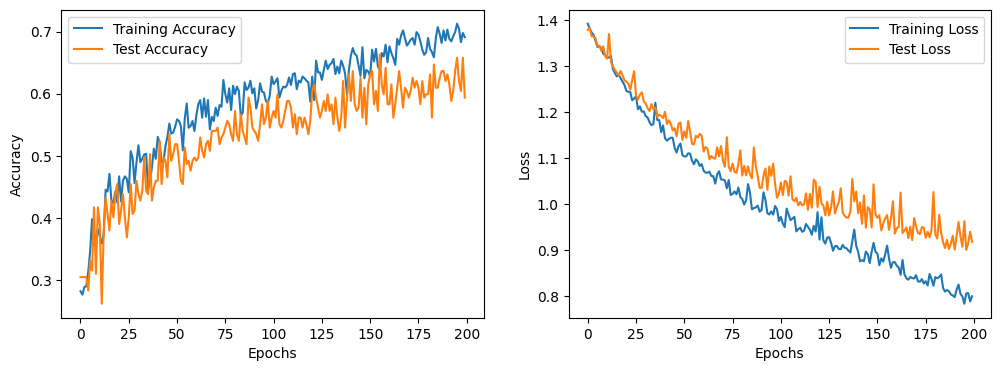

In [ ]:
test_loss, test_acc = resnet_model.evaluate(x_test, test_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
predictions_resnet = resnet_model.predict(x_test)
binary_predictions_resnet = np.argmax(predictions_resnet, axis=1)
test_labels = test_labels.reshape(-1, 1)
# Calculate metrics
conf_matrix_resnet = confusion_matrix(test_labels, binary_predictions_resnet)
accuracy_resnet = np.trace(conf_matrix_resnet) / np.sum(conf_matrix_resnet)
precision_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=0)
recall_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=1)
f1_score_resnet = 2 * (precision_resnet * recall_resnet) / (precision_resnet + recall_resnet)

# Specificity
num_classes_resnet = len(conf_matrix_resnet)
specificity_resnet = []
for i in range(num_classes_resnet):
    true_negatives_resnet = np.sum(conf_matrix_resnet) - np.sum(conf_matrix_resnet[i, :]) - np.sum(conf_matrix_resnet[:, i]) + conf_matrix_resnet[i, i]
    false_positives_resnet = np.sum(conf_matrix_resnet[:, i]) - conf_matrix_resnet[i, i]
    specificity_class_resnet = true_negatives_resnet / (true_negatives_resnet + false_positives_resnet)
    specificity_resnet.append(specificity_class_resnet)

average_specificity_resnet = np.mean(specificity_resnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_resnet)

# Print the metrics
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet}")
print(f"Recall: {recall_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Specificity for each class: {specificity_resnet}")
print(f"Average Specificity: {average_specificity_resnet}")

6/6 [==============================] - 1s 13ms/step
Confusion Matrix:
[[34  4  0 10]
 [16 12  4 15]
 [ 5  3 16 11]
 [ 3  2  3 49]]
Accuracy: 0.5936
Precision: [0.5862069  0.57142857 0.69565217 0.57647059]
Recall: [0.70833333 0.25531915 0.45714286 0.85964912]
F1 Score: [0.64150943 0.35294118 0.55172414 0.69014085]
Specificity for each class: [0.8273381294964028, 0.9357142857142857, 0.9539473684210527, 0.7230769230769231]
Average Specificity: 0.8600191766771661


In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 141.21346139907837 seconds.
